# Лабораторные работы по Имитационному Моделированию
### Выполнил: Семён Сергеев

## Лабораторная № 1.  Обработка заказов грузовой компании.

Моделируется работа грузовой компании с парком машин, габаритных и негабаритных. Заказы того и другого типа приходят по распределению Пуассона со своими средними, а длительность заказов может быть различна, но для габаритных немного больше. Время дискретно с шагом в одну минуту.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

In [163]:
class Order():
    def __init__(self, sz, order_t):
        self.size = sz
        self.time = order_t
        self.status = 0
        self.waiting_time = 0
        
def RunSimCompany(n_small, # Число негабаритных машин
               n_large,  # Число габаритных машин
               rate_small, # Среднее число негабаритных заказов
               rate_large, # Среднее число габаритных заказов
               t, # Время моделирования
               areas_of_time, # В каких границах могут быть длительности заказов
               info # Показывать ли информацию
              ):
    x = np.arange(t)
    waiting_times = []
    available = [n_small, n_large]
    orders = []
    for i in x:
        large_count = np.random.poisson(rate_large)
        small_count = np.random.poisson(rate_small)
        orders += (AddOrdersByType(0, small_count, areas_of_time[0]) + AddOrdersByType(1, large_count, areas_of_time[1]))
        next_orders = []
        for order in orders:
            s = order.size
            if order.status == 1:
                order.time -= 1
                if order.time == 0:
                    available[s] += 1
                    waiting_times.append(order.waiting_time)
                else:
                    next_orders.append(order)
            else:
                next_orders.append(order)
                if available[s]:
                    order.status = 1
                    available[s] -= 1
                else:
                    order.waiting_time += 1
        orders = next_orders
    if info:
        print("Максимальное время ожидания: ", np.max(waiting_times))
        print("Среднее время ожидания: ", np.mean(waiting_times))
        print("Длина очереди на конец работы: ", len(orders))
        print("График времён ожидания по очереди:")
        _, ax = plt.subplots(figsize=(15, 7))
        ax.plot(np.arange(len(waiting_times)),waiting_times)
        plt.show()
        print("Гистограмма времён ожидания:")
        _, ax = plt.subplots(figsize=(15, 7))
        plt.hist(waiting_times, bins=25)
        plt.show()
    return np.max(waiting_times), np.mean(waiting_times)

def AddOrdersByType(sz, count, area_of_time):
    return [Order(sz,np.random.randint(area_of_time[0], area_of_time[1]+1)) for _ in range(count)]

Найдём длину очереди при моделировании четырёх часов работы:

Максимальное время ожидания:  21
Среднее время ожидания:  2.3917525773195876
Длина очереди на конец работы:  19
График времён ожидания по очереди:


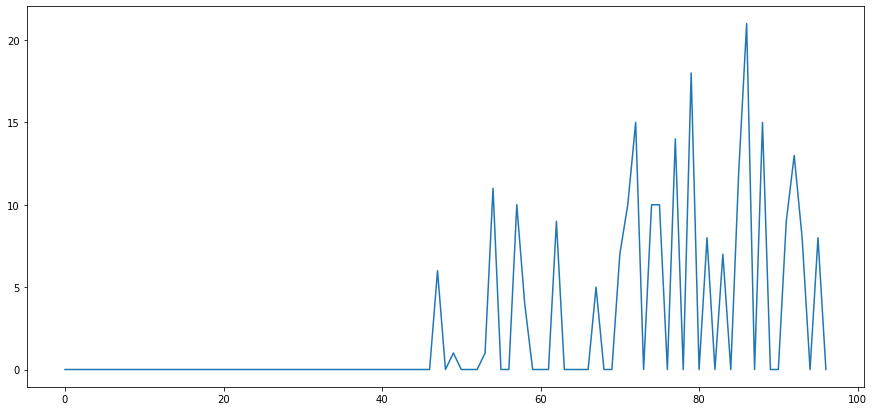

Гистограмма времён ожидания:


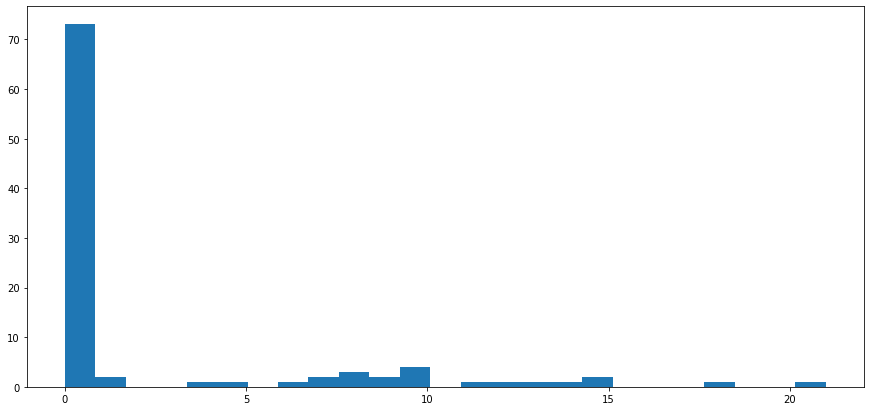

In [171]:
RunSimCompany(13,19,0.2,0.3,240,[[10,45],[30,100]],True)
pass

Для неплохого среднего и максимального времени у нас получилась довольно длинная очередь. Но она очень быстро продвигается.

Найдём оптимальное соотношение машин при их фиксированном общем числе и остальных параметрах. Опираться будем на максимальное время ожидания.

Зависимость макс. времени ожидания от числа малых машин при фиксированном общем числе


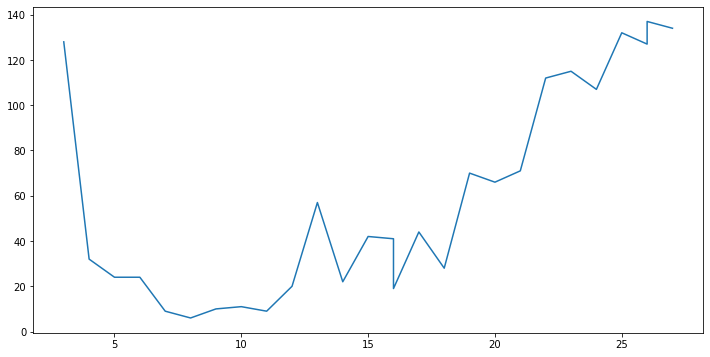

In [182]:
m = 30
x = np.arange(0.1,0.91,0.03)
sm = [round(m*r) for r in x]
lm = [m-r for r in sm]
res = []
for i in range(len(sm)):
    t,_ = RunSimCompany(sm[i],lm[i],0.2,0.3,240,[[10,45],[30,100]],False)
    res.append(t)
_, ax = plt.subplots(figsize=(12, 6))
print('Зависимость макс. времени ожидания от числа малых машин при фиксированном общем числе')
ax.plot(sm,res)
pass

Задача решена, оптимальное число негабаритных машин = 8, это минимум на графике выше. Значит грузовых машин должно быть 22. При этом максимальное время ожидания около 10 минут, что очень мало.

## Лабораторная № 2.  Заполняемость университета.

Моделируется стандартное посещение пар в университете на протяжении одного дня. За день мы считаем несколько подряд идущих пар. $N$ студентов, количество, которое в этот день фиксировано, должно их посещать. 

На каждое занятие студенты приходят не одновременно, "кто-то раньше, кто-то позже". Очевидно, что есть фокусная точка - время начала пары. Ясно также, что чем дальше от неё - тем меньше людей в это время будет приходить, например прибытие за 5 часов до пары крайне маловероятно. Можно предположить, что это убывание симметрично. Учитываем, что приходят они ещё и независимо друг от друга, а время прибытия сама по себе величина непрерывная. Сразу же ясно, что распределение времени прибытия - нормальное, где матожиданием будет время начала пары, а дисперсия может меняться. 

Если студенты сразу же по прибытии будут попадать на пару, то модель будет не очень-то интересной, поэтому добавим пропускную способность двери на вход (предположим там сидит охранник, который проверяет студенческие), а также добавим некоторое случайное время, которое нужно, чтобы внутри университета добраться до аудитории. 

На отметке 15 минут после начала пары все двери закрываются, фиксируем посещение пар (заполняемость). Те, кто не успел, временно уходят. После окончания пары некоторая доля людей остаётся и только лишь меняет аудиторию с тем же небольшим случайным временем. Остальные уходят и снова возвращаются во время, распределённое по нормальному закону.

Используем дискретное время с шагом в одну минуту (округлим результаты времени прибытия до минуты). Сама длина пары не важна, это не влияет на поведение модели, поскольку в это время нет никаких действий. Перерыв сделаем симметрично 15-минутной отметке для удобства.

Таким образом модель подробно описана, теперь можно реализовать её программно.

In [526]:
class Student():
    def __init__(self):
        self.status = 0 
        
        #status codes: 
        #0 - местонахождение неизвестно
        #1 - время прихода известно, готов ко входу
        #2 - внутри университета, идёт в аудиторию
        #3 - на паре
        
        self.arrive_time = 0
        self.inside_time = 0
        

def RunSimUn(n_students, # Число студенов
             entry_throughput, # Пропускная способность входа (чел/мин)
             stay_ratio, # Доля студентов, которые только меняют 
                         # аудиторию после пары (остальные уходят)
             ins, # range времени от двери до аудитории [a,b]
             disp, # Дисперсия для распределения времени прибытия
             n_lessons, # Число пар в модельных сутках (45 минут пара, 
                # 15 минут перерыв, начало пар в 9.00, отсчёт с 8.45)
             info # Выдавать ли информацию
            ):
    students = [Student() for i in range(n_students)]
    next_lesson = 15
    seated_hist = []
    passed_hist = []
    seated = 0
    reset = False
    avg_in = []
    x = np.arange(60*(n_lessons))
    for i in x:
        
        step_limit = entry_throughput
        if i == next_lesson+15:
            avg_in.append(seated)
            
        if i == next_lesson+45:
            next_lesson+=60
            reset = True

        for s in students:
            
            # По окончании пары перемещаем часть людей, из тех, 
            # которые на ней были, в другие аудитории. Остальные уходят, 
            # чтобы затем вернуться в произвольное время
            if reset:
                if s.status == 3:
                    seated-=1
                    if np.random.rand() < stay_ratio :
                        s.status = 2
                    else:
                        s.status = 0
                else:
                    s.status = 0
            # За 15 минут до пары генерируем время прибытия
            if i == next_lesson-15 and s.status == 0:
                s.arrive_time = max(i,round(np.random.normal(next_lesson,disp)))
                s.status = 1
            # Продвижение в очереди у двери
            if step_limit and s.status == 1 and s.arrive_time <= i and i < next_lesson+15:
                s.status = 2
                s.inside_time = np.random.randint(ins[0],ins[1] + 1)
                step_limit-=1
            # Продвижение к аудитории внутри университета и посадка на место
            if s.status == 2 and i < next_lesson + 15:
                if s.inside_time:
                    s.inside_time-=1
                else:
                    s.status = 3
                    seated += 1
                          
        seated_hist.append(seated)
        passed_hist.append(entry_throughput-step_limit)
        reset = False
    if info:
        print('Заполняемость на каждой паре:')  
        print(avg_in)
        print(np.divide(avg_in,n_students))
        _, ax = plt.subplots(figsize=(12, 6))
        plt.ylim([0,n_students])
        ax.plot(x,seated_hist,label='В аудитории')
        ax.plot(x,passed_hist,label = 'Проходит через дверь')
        ax.legend()
        print('Средняя заполняемость:')
        print(np.mean(avg_in))
        print(np.mean(avg_in)/n_students)
    return np.mean(avg_in)
        
    


Запустим симуляцию и посмотрим, что получается.

Заполняемость на каждой паре:
[618, 843, 887, 931, 933]
[0.618 0.843 0.887 0.931 0.933]
Средняя заполняемость:
842.4
0.8423999999999999


842.4

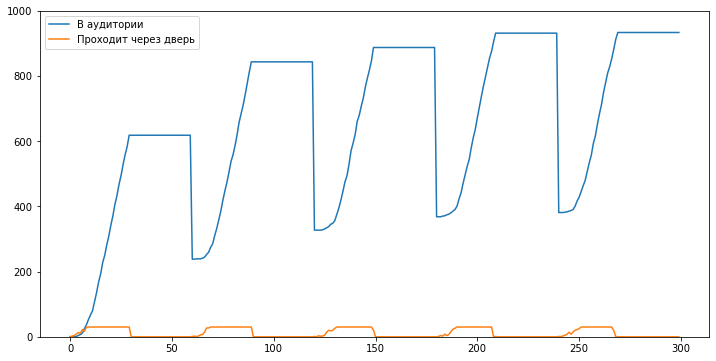

In [527]:
RunSimUn(1000,30,0.4,[1,7],5,5, True)

Вывод вполне соответствует естественным ожиданиям. 5 пар, довольно низкая пропускная способность на входе (больше 900 человек вообще не способно пройти за отведённые полчаса, а всего у нас их 1000), при этом от 1 до 7 минут они добираются до аудитории. 
Сначала из-за низкой П/C опоздало около 40% студентов, но затем всё начало стабилизироваться, за счёт тех, что остаются внутри здания. В итоге недобор около 100 человек в конце за счёт тех, кто приходит совсем уж поздно и, немного задержавшись на входе, каждый раз не успевает добраться до кабинета, будучи уже внутри здания.

Заполняемость на каждой паре:
[893, 983, 975, 986, 986]
[0.893 0.983 0.975 0.986 0.986]
Средняя заполняемость:
964.6
0.9646


964.6

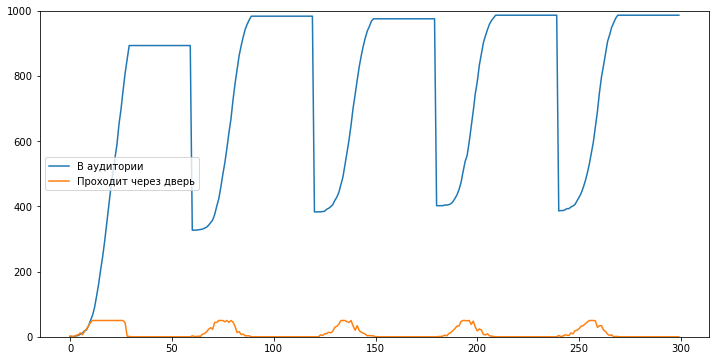

In [447]:
RunSimUn(1000,50,0.4,[1,7],5,5, True)

Немного повышенная пропускная способность сразу же исправляет ситуацию.

Исследуем модель, будем варьировать различные параметры на отрезке и строить график зависимости средней заполняемости от этого параметра.

#### Число студентов

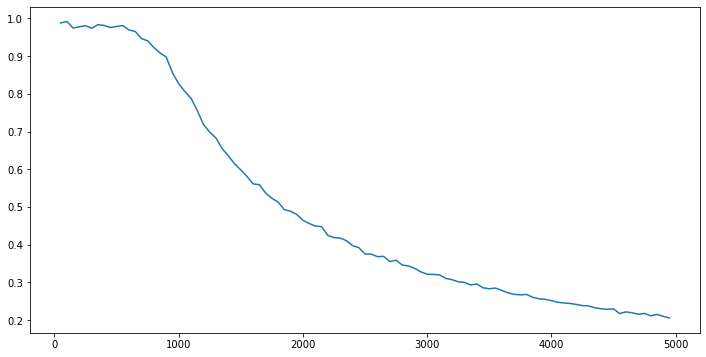

In [453]:
x = np.arange(50,5000,50)
y = [RunSimUn(n,30,0.4,[1,7],5,5, False)/n for n in x]
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(x,y)

До 1000 заполняемость находится на довольно высоком уровне, затем начинает падать, поскольку пропускной способности не хватает. Такая же картина будет сохраняться, если её поднять, при этом начало падения просто сместится правее.

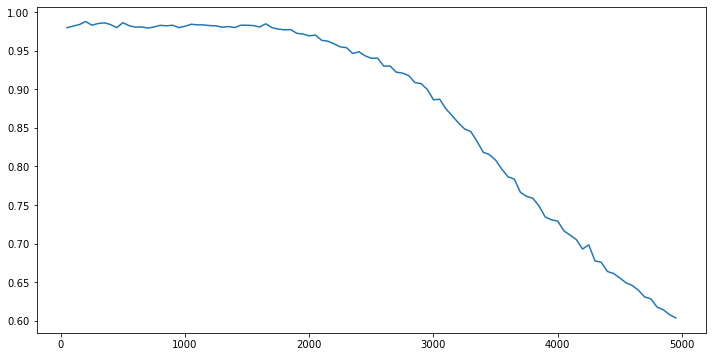

In [454]:
x = np.arange(50,5000,50)
y = [RunSimUn(n,100,0.4,[1,7],5,5, False)/n for n in x]
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(x,y)

Не доходим до 100% за счёт очень поздно приходящих студентов, которых не спасло бы и отстутствие П/C.
#### Пропускная способность

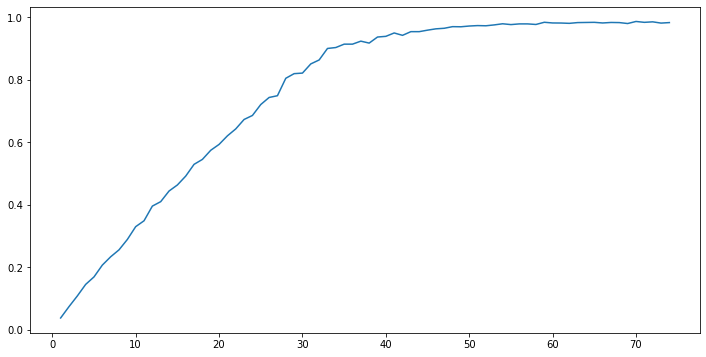

In [458]:
x = np.arange(1,75,1)
y = [RunSimUn(1000,n,0.4,[1,7],5,5, False)/1000 for n in x]
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(x,y)

Всё ожидаемо - линейный рост заполняемости при линейном росте П/С, до того момента, когда мы упираемся в предел по росту. Так можно легко найти оптимальную П/C для заданного числа студентов. Например здесь она около 40.

#### Количество остающихся

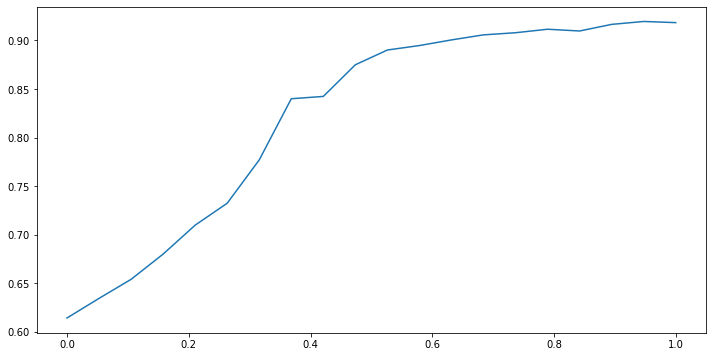

In [459]:
x = np.linspace(0,1,20)
y = [RunSimUn(1000,30,n,[1,7],5,5, False)/1000 for n in x]
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(x,y)

Чем больше людей не уходит из университета - тем больше не опаздывает. Всё закономерно.

Число пар влияет на поведение системы слабо, но сильнее при малой П/C, когда не все успевают пройти дверь.
При увеличении среднего времени достижения аудитории заполняемость снижается, это очевидно.

#### Дисперсия

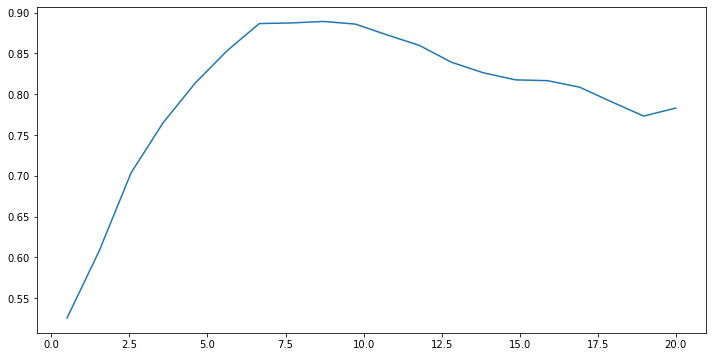

In [461]:
x = np.linspace(0.5,20,20)
y = [RunSimUn(1000,30,0.4,[1,7],n,5, False)/1000 for n in x]
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(x,y)

Когда люди приходят заранее - это хорошо для системы, но поскольку распределение симметрично, то так же много людей приходят и слишком поздно, отсюда падение заполняемости.

## Лабораторная №3. Конвейер на производстве.

Моделируется простой конвейер с несколькими этапами работы, на каждом своё время, а в начале может образовываться очередь из поставляемых регулярно деталей. Определить оптимальное время поставки и время работы на этапах. Время в модели дискретно с шагом в одну секунду.

In [102]:
from itertools import product 

In [130]:
def RunConveerSim(n_phases,  # Этапов на конвейере
                  process_t , # Если None, то случайное время для каждого этапа в радиусе [5,10], иначе задано вручную
                  details_t, # Время, когда поставляются детали в начало конвейера
                  t): # Время моделирования
    
    
    conveer = [-1]*n_phases
    x = np.arange(t)
    idle_time = 0
    details_n = 0
    if process_t is None:
        process_t = [np.random.randint(5,22) for _ in range(n_phases)]
    for i in x:
        if i%details_t == 0:
            details_n += 1
        shift = True
        for j, st in enumerate(conveer):
            idle_time += 1
            if st != -1:
                if st > 0:
                    conveer[j] -= 1
                    idle_time -=1
                    shift = False
        if shift:
            idle_time -= n_phases
            conveer.pop(-1)
            new_cycle = -1
            if details_n > 0:
                details_n -= 1
                new_cycle = process_t[0]
            conveer = [new_cycle] + conveer
            for k in range(1,len(conveer)):
                if conveer[k] != -1:
                    conveer[k]= process_t[k]
        
    return idle_time, details_n

Попробуем найти оптимальные по idle time времена работы перебором и взятием минимума для конвейера размером 5 и с бесперебойной подачей деталей:

In [132]:
test = list(product([1,2,3,4,5],repeat = 5))
test = [list(elem) for elem in test]

In [133]:
res = []
for t in test:
    it, _ = RunConveerSim(5, t ,2, 60)
    res.append(it)
print('Оптимальное время выполнения')
print(test[np.argmin(res)])

Оптимальное время выполнения
[1, 1, 1, 1, 1]


То есть для бесперебойной поставки каждый тик нужно использовать одинаковые времена. Если увеличить время поставки:

In [134]:
res = []
for t in test:
    it, _ = RunConveerSim(5, t ,4, 60)
    res.append(it)
print('Оптимальное время выполнения')
print(test[np.argmin(res)])

Оптимальное время выполнения
[3, 3, 3, 3, 3]


Всё равно одинаковое, по формуле (details_t-1).

Теперь найдём оптимальное время поставки для фиксированного неоптимального конвейера:

In [135]:
test = np.arange(1,20)
res = []
dqres = []
for t in test:
    it, dq = RunConveerSim(5, [4,5,6,5,7] ,t, 60)
    res.append(it)
    dqres.append(dq)
print('Оптимальное время доставки')
print(test[np.argmin(res)])
print('Очередь в начале:')
print(dqres[np.argmin(res)])

Оптимальное время доставки
1
Очередь в начале:
51


При оптимальном по idle_time времени поставок в начале образуется длинная очередь. Нужно выбирать время с учётом обоих показателей.

## Лабораторная №4. Обслуживание в банке.

Моделируется работа банка с несколькими окнами обслуживания. Клиенты приходят независимо друг от друга, в течение неопределённого времени, с некой интенсивностью. Здесь идеально подходит распределение Пуассона, которое и моделирует подобные ситуации. Каждый клиент требует от 5 до 30 минут работы одного окна. Чем больше время ожидания в очереди - тем более недоволен клиент. 

Исследуем разные способы распределения клиентов по окнам, чтобы минимизировать недовольство. Случайное распределение, распределение туда, где меньше людей, или туда, где суммарное время задач стоящих в очереди меньше.
И снова используем дискретное время с шагом в 1 минуту.

Можно использовать разные метрики недовольства, но нам, наверное, интересны две основные - наиболее недовольный клиент и недовольство клиентов в среднем.

Реализуем модель:

In [4]:
class Client():
    def __init__(self,task_time):
        self.task_time = task_time
        self.waiting_time = 0

def RunSimBank(n_windows, # Число окон обслуживания
               rate, # интенсивность поступления клиентов для распределения Пуассона
               distr, # способ распределения клиентов по окнам (0 - случайно, 
                                            #  1 - там, где меньше людей, 
                                            #  2 - там, где меньше суммарное время задач)
               t,# время симуляции (в минутах) 
               info # Выдавать ли информацию
              ):
    windows = [[] for i in range(n_windows)]
    x = np.arange(t)
    sat = []
    for i in x:
        
        # Генерируем новых клиентов
        new_clients = np.random.poisson(rate)
        
        # Раскладываем их по окнам в соответствии с принятой стратегией
        for j in range(new_clients):
            lens = [len(w) for w in windows]
            times = [sum([c.task_time for c in w]) for w in windows ]
            c = Client(np.random.randint(5,31))
            if distr == 0:
                ind = np.random.randint(n_windows)
            elif distr == 1: 
                ind = np.argmin(lens)
            elif distr == 2:
                ind = np.argmin(times)
            windows[ind].append(c)
            
        # Проходим по очередям в окнах
        for w in windows:
            if w: 
                for k in range(1,len(w)):
                    w[k].waiting_time+=1
                if w[0].task_time > 0:
                    w[0].task_time-=1
                else:
                    sat.append(w[0].waiting_time)
                    w.pop(0)
    if info:
        print("Самый недовольный клиент: ", np.max(sat))
        print("Средний уровень недовольства: ", np.mean(sat))
        _, ax = plt.subplots(figsize=(12, 6))
        ax.plot(np.arange(len(sat)),sat,label='Время ожидания')
        ax.legend()
        _, ax = plt.subplots(figsize=(12, 6))
        plt.hist(sat,50)
    return np.max(sat),np.mean(sat)
    
    

Проверим модель с высокой интенсивностью клиентов (0.7 чел/мин) и 15 окнами на 100 часах работы, при этом по окнам они распределяются случайно.

Самый недовольный клиент:  366
Средний уровень недовольства:  53.785556915544674


(366, 53.785556915544674)

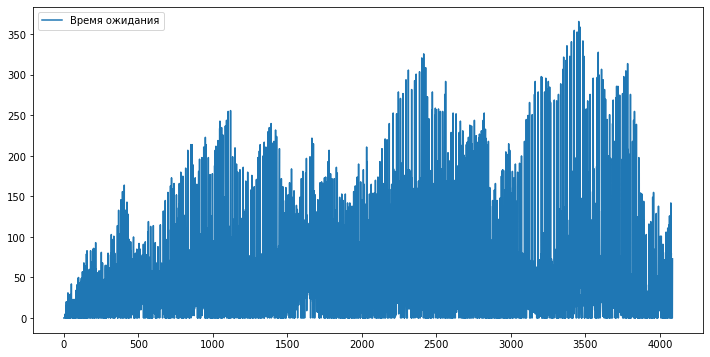

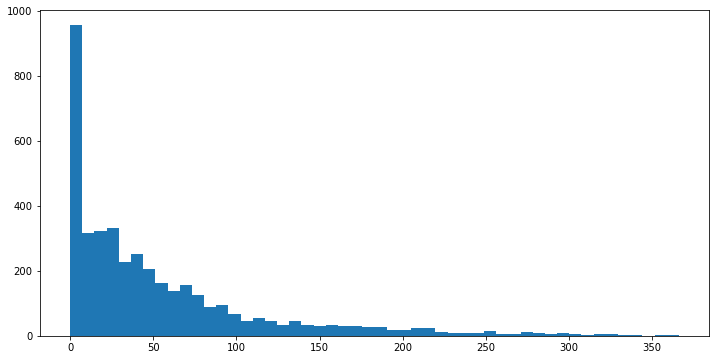

In [5]:
RunSimBank(15,0.7,0,6000,True)

Можно посмотреть на среднее и максимальное время ожидания (ВО).
На графике представлено ВО клиентов в том порядке, как они уходили из банка, а ниже гистограмма ВО.
Видно, что время ожидания при таком неэффективном подходе ужасное: в среднем нужно ждать час, а максимально - безумные 6 часов. При этом довольно много клиентов всё же не ждали ни минуты. Попробуем менять стратегии.

Самый недовольный клиент:  44
Средний уровень недовольства:  4.12136385312351


(44, 4.12136385312351)

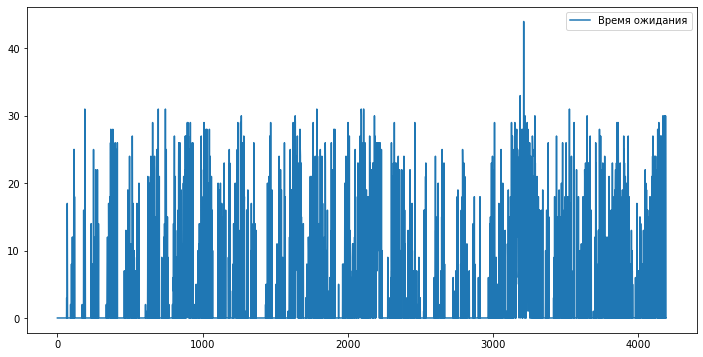

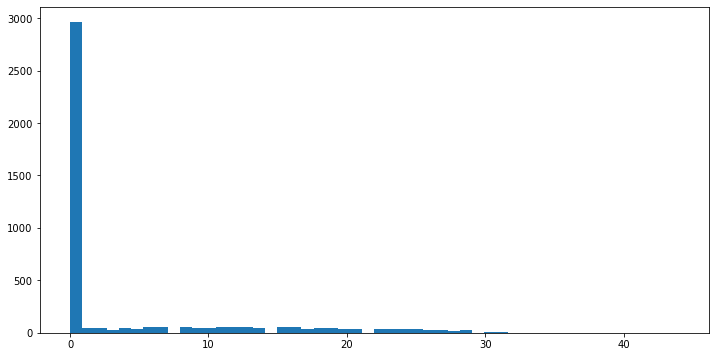

In [486]:
RunSimBank(15,0.7,1,6000,True)

Ситуация стала намного лучше. Среднее время ожидания всего 4 минуты, а самому неудачливому клиенту пришлось ждать всего 44, что не так уж и много. Попробуем последнюю стратегию.

Самый недовольный клиент:  29
Средний уровень недовольства:  2.8463919980947843


(29, 2.8463919980947843)

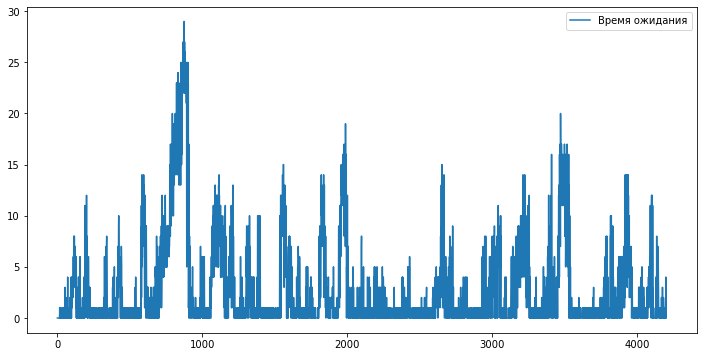

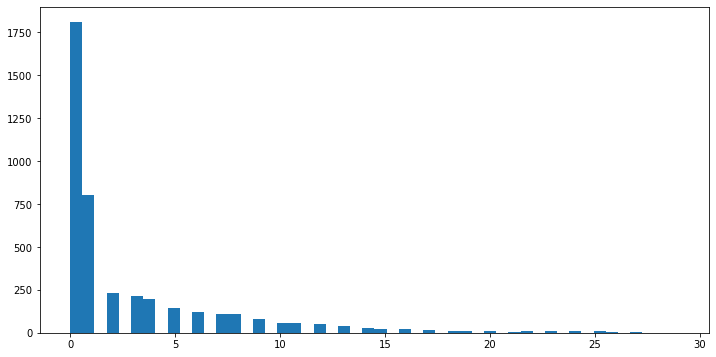

In [492]:
RunSimBank(15,0.7,2,6000,True)

Нужно признать, что эта стратегия получилась самой эффективной 2.84/29 минут ВО, но отмечаем, что без заранее определённого времени работы с клиентом такого планирования провести нельзя. Также получился интересный график, где времена ожидания кажутся "синхронизированными" из-за планирования, тогда как раньше они были вразнобой.

Попробуем ещё найти оптимальное количество окон при данной стратегии и фиксированной интенсивности (повысим её).

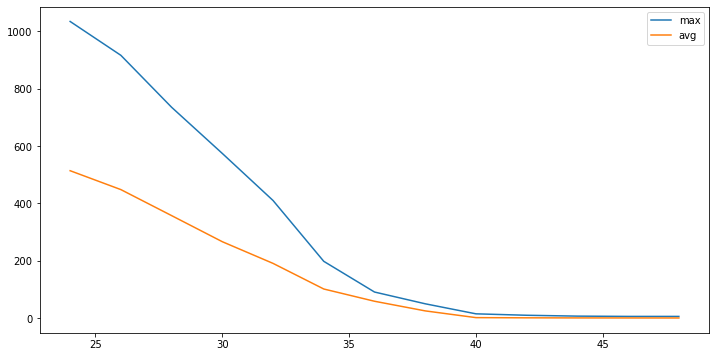

In [500]:
x = np.arange(24,50,2)
y = [RunSimBank(n,2,2,3000,False) for n in x]
y1,y2 = zip(*y)
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(x,y1,label='max')
ax.plot(x,y2,label='avg')
ax.legend()

Видим, что при разумной стратегии планирования на интенсивность 2 чел/минуту хватает всего около 40 окон. При этом того же числа не хватает даже для 0.5 чел/минут, если ничего не планировать - там максимальное время ожидания около часа. Среднее довольно маленькое - брутфорсится слишком большим числом окон для такого потока людей.

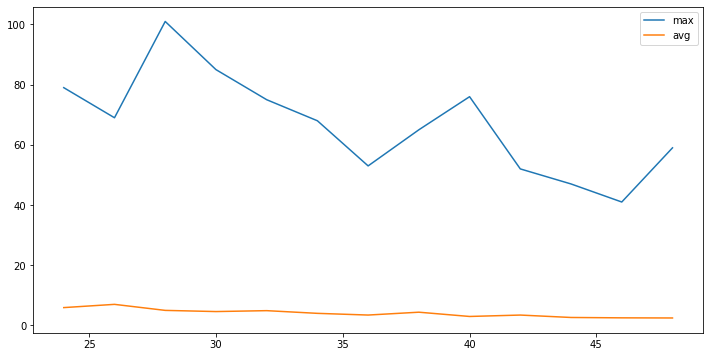

In [501]:
x = np.arange(24,50,2)
y = [RunSimBank(n,0.5,0,3000,False) for n in x]
y1,y2 = zip(*y)
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(x,y1,label='max')
ax.plot(x,y2,label='avg')
ax.legend()

## Лабораторная №5. Перестрелка.

Итак, описание самостоятельно придуманной модели:
Перестреливаются два отряда солдат, союзный и вражеский. Оба могут состоять из солдат разного уровня подготовки (3 уровня), у каждого своя скорость и  точность стрельбы, умение укрыться от вражеской, а также условная "стоимость", будем считать это затратами ресурсов на его обучение, снаряжение и переброс сюда (что-то из этого). 
Вражеский отряд состоит из случайного набора солдат, а на снаряжение союзной есть ограниченное число средств.
Попробуем моделировать разные способы подбора состава при различных доступных ресурсах. Цель - победить вражеский отряд, уложившись в ресурс. 

Решение и вообще поведение модели сильно зависит от характеристик солдат, с ними можно долго играться, но я постарался подобрать адекватные параметры. (Новобранец/Тренированный/Бывалый солдат)

Дискретное время, 0.1 секунда шаг. Перестрелка на шаге происходит одновременно, приоритета стороны нет.

* Логико-математическая модель:

$soldier \in \{(stats_1,cost_1),(stats_2,cost_2),(stats_3,cost_3)\}$

$enemies = n \ \text{of} \ random(soldier)$

$allies = \{ soldier1, .. \}$

$strategies = \{s_1,s_2,..,s_6\}$

$cost(allies) < resources \land s_i(allies) = True $

Пока живы обе армии:

$ allies <- shootout -> enemies$

In [522]:
premade_stats = [[0.02,0.3,0.2,1],[0.05,0.4,0.3,3],[0.12,0.7,0.4,6]]
class Soldier():
    def __init__(self,skill_level):
        st = premade_stats[skill_level]
        self.fire_rate = st[0] # Скорость стрельбы, выстрелов за единицу времени
        self.hit_chance = st[1] # Точность стрельбы
        self.evade_chance = st[2] # Умение укрыться
        self.cost = st[3] # Стоимость набора
        self.accum = 0 

def RunSimBattle(n_enemies, # Число врагов
                 resources, # объём доступных ресурсов 
                 strategy,  # По какому принципу набираем состав
                            # 0 - предпочтение слабым 
                            # 1 - предпочтение средним
                            # 2 - предпочтение сильным
                            # 3 - поровну (по числу людей)
                            # 4 - поровну (по потраченным ресурсам)
                            # 5 - случайно
                 info
              ):
    
    # Функция для заполнения отряда, начиная с заданного приоритета, и ниже, то, на что хватит места
    def descend_fill(top,curr_res):
        for i in range(top,-1,-1):
            n = curr_res//premade_stats[i][3]
            curr_res %= premade_stats[i][3]
            allies.extend([Soldier(i) for j in range(n)])
            
    enemies = [Soldier(np.random.randint(3)) for i in range(n_enemies)]
    allies = []
    
    # Заполнение отряда в согласии со стратегией
    if strategy <=2:
        descend_fill(strategy,resources)
    elif strategy == 3:
        s = premade_stats[0][3] + premade_stats[1][3] + premade_stats[2][3]
        n = resources//s
        leftover = resources%s
        allies.extend([Soldier(0) for i in range(n)])
        allies.extend([Soldier(1) for i in range(n)])
        allies.extend([Soldier(2) for i in range(n)])
        descend_fill(2,leftover)
    elif strategy == 4:
        part = resources//3
        leftover=resources%3
        for k in range(3):
            allies.extend([Soldier(k) for m in range(part//premade_stats[k][3])])
            leftover+=part%premade_stats[k][3]
        descend_fill(2,leftover)
    elif strategy == 5:
        summary = 0
        while True:
            skill = np.random.randint(3)
            summary +=premade_stats[skill][3]
            if summary > resources: 
                summary-=premade_stats[skill][3]
                break
            allies.append(Soldier(skill))
        descend_fill(2,resources-summary)
        
    x = []
    cur_enemies = []
    cur_allies = []
    t = 0
    # Функция стрельбы одной стороны в другую. Удобно, потому что перестрелка симметрична
    # Возвращает метки тех, кто уже мёртв на следующий тик времени.
    def shootout(give, receive):
        marked = []
        for p in give: 
            if p.accum < 1:
                p.accum+=p.fire_rate
            elif len(marked) < len(receive): # Если ещё есть в кого стрелять
                p.accum = 0
                # Выбираем из непомеченных
                target = np.random.choice([ind for ind in range(len(receive)) if ind not in marked]) 
                # Проверяем на попадание и уклонение
                if np.random.rand() < p.hit_chance*(1-receive[target].evade_chance):  
                    marked.append(target)
        return marked
    # Основной цикл работы продолжается пока один отряд не опустеет
    while len(allies) and len(enemies): 
        x.append(t)
        t+=0.1
        
        #Симметричная перестрелка
        am = shootout(enemies,allies)
        em = shootout(allies,enemies)
        
        # Сокращение отрядов по меткам
        allies = [i for j, i in enumerate(allies) if j not in am]
        enemies = [i for j, i in enumerate(enemies) if j not in em]
        
        cur_allies.append(len(allies))
        cur_enemies.append(len(enemies))
    if info:
        _, ax = plt.subplots(figsize=(12, 6))
        plt.ylim([0,max(n_enemies+10,cur_allies[0] +10)])
        ax.plot(x,cur_allies,label='allies')
        ax.plot(x,cur_enemies, label='enemies')
        ax.legend()
         # Кто победил и survival_rate
    return len(allies) > len(enemies), cur_allies[-1]/cur_allies[0]

Посмотрим на результаты работы, если на 300 новобранцев натравить 100 случайных солдат. 

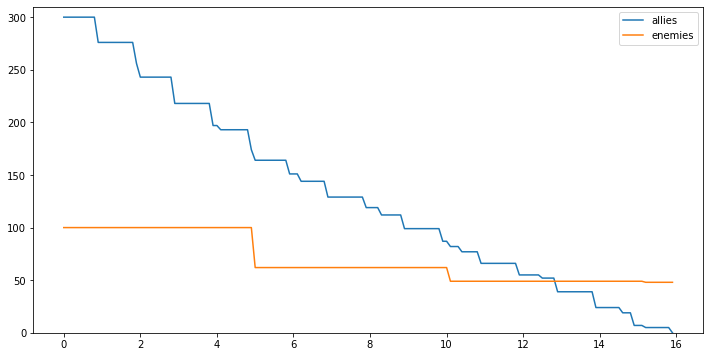

In [506]:
RunSimBattle(100,300,0,True)

Не справляются, попробуем другие стратегии с теми же ресурсами.

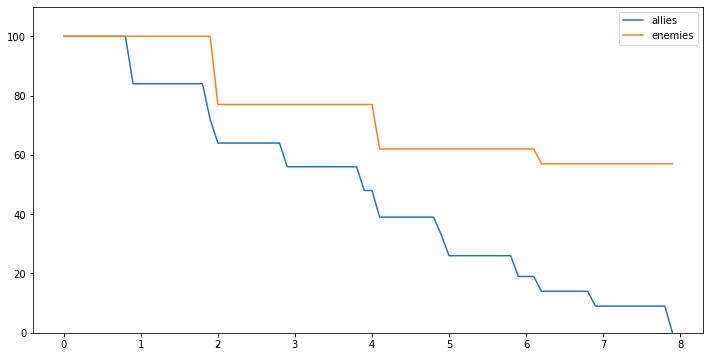

In [507]:
RunSimBattle(100,300,1,True)

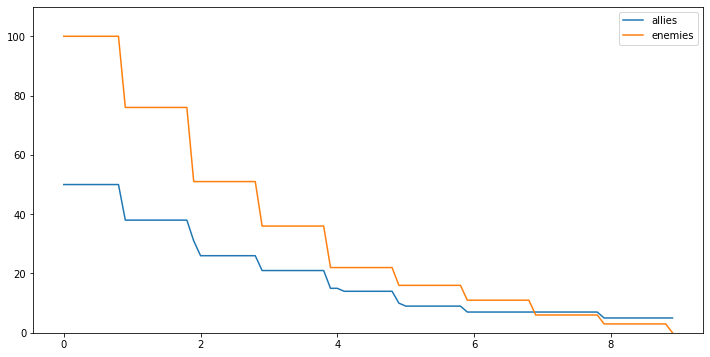

In [508]:
RunSimBattle(100,300,2,True)

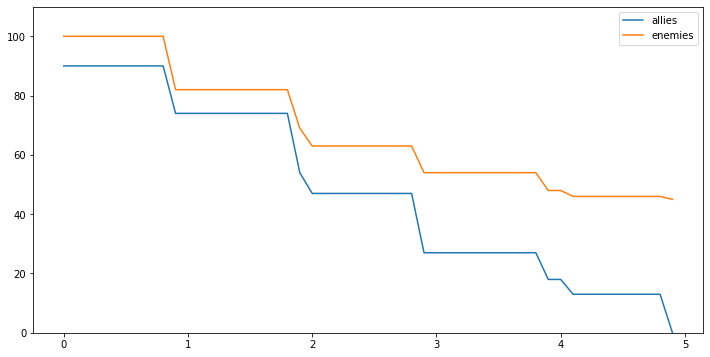

In [509]:
RunSimBattle(100,300,3,True)

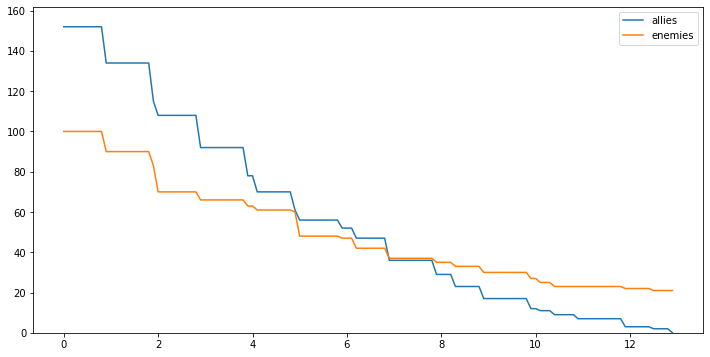

In [510]:
RunSimBattle(100,300,4,True)

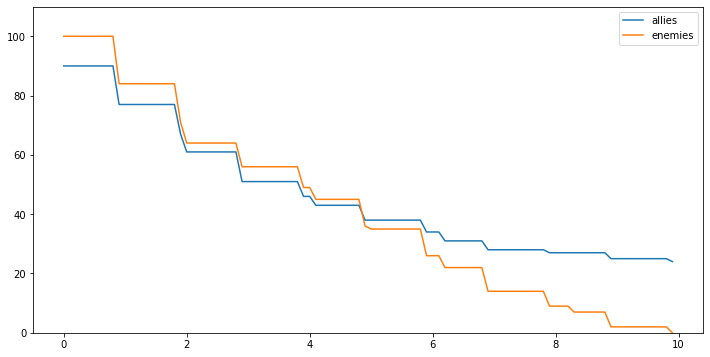

In [511]:
RunSimBattle(100,300,5,True)

Итого получается, что 50 сильных солдат смогли дать бой сотне и победить, а также выиграл случайный отряд из 90 человек (это, скорее всего, уже случайность). А вот 160 человек, где на каждую группу приходилось одинаково ресурсов, победить не смогли.

Такой подход к исследованию модели не очень хороший, поскольку сильно зависит от рандома и заданных параметров солдат.
Есть другой подход, который это немного сглаживает: будем фиксировать стратегию и наращивать ресурс, пока не начнём стабильно побеждать. Так можно сделать для разного числа противников и таким образом качественно исследовать стратегии.

Кстати, сражения заканчиваются за 5-15 секунд, возможно стоит называть эти шаги не 0.1 сек, а 0.1 мин, тогда это будет более реалистично.

In [514]:
result = []
for i in range(6):
    k = 0
    r = 10
    while k<3:
        won,_ = RunSimBattle(100,r,i,False)
        if won:
            k+=1
        r+=5
    result.append(r)

In [515]:
print(result)

[315, 455, 370, 350, 330, 340]


In [517]:
result = []
for i in range(6):
    k = 0
    r = 500
    while k<3:
        won,_ = RunSimBattle(200,r,i,False)
        if won:
            k+=1
        r+=50
    result.append(r)
print(result)

[850, 1050, 900, 800, 800, 800]


Здесь можно сказать, что взять по максимуму неумелых солдат при данных параметрах - рабочая стратегия и довольно выгодная (видимо, параметры можно задать и получше).
Самыми худшими оказались стратегии взять только средних и только сильных. Случайное и равномерные распределения довольно похожи при большом числе солдать, поэтому и ресурсоёмкость у них похожа.

А теперь посмотрим на отношение (ресурсы /( оставшиеся в живых союзники/ всего союзников)). Мы ведь и потери хотим уменьшить.

In [524]:
result = []
for i in range(6):
    k = 0
    r = 300
    while k<3:
        won,survival_rate = RunSimBattle(100,r,i,False)
        if won:
            k+=1
        r+=5
    result.append(r/survival_rate)
print(result)

[1178.5714285714284, 2975.0, 952.8571428571429, 2072.8125, 928.5714285714287, 2034.0]


А вот тут картина немного другая и намного более интересная. Стратегии, которые раньше казались выгодными теперь вовсе не так хороши. Объективно, если командование ценит человеческую жизнь - выгоднее потратить больше ресурсов.
Самые лучшие по этому критерию отряды - сильный и равноресурсный, худшие - средний, случайный, равносборный. Слабый находится ближе к лучшей строне критерия, видимо, относительно немного солдат там погибает.